In [1]:
#Import things
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [2]:
#Function things
def func(x,y):
    f = np.exp(-0.2*(x**4+y**4))+np.exp(np.cos(2*np.pi*x)+np.cos(2*np.pi*y))
    return f

In [3]:
#Creating the initial population. (With Constraint)
def initpop(npop):
    new_pop = np.zeros([1,2]) 
    while(True):
        if new_pop.shape[0]>npop:
            break
        else:
            x = np.random.uniform(-1,2)
            y = np.random.uniform(-2,1)
            #check
            if x+y<=1:
                new_pop = np.append(new_pop,[[x,y]],axis=0)
    new_pop = new_pop[1:]
    return new_pop
#Create initial velocity
def initvelo(npop):
    return np.random.uniform(-1,1,(ind,2))

In [4]:
#Auto fitness calculation, --input matri, output matrix
def fitnes(pop):
    rslt = np.zeros([pop.shape[0],1])
    for i in range(pop.shape[0]):
        rslt[i] = func(pop[i,0],pop[i,1])
    return rslt

In [5]:
# Constraint Penalty
# Static Penalty 
# rank 1 1<x+y<2, rank 2 2<x+y<4, rank 3 4<x+y<8, rank 4 8<x+y<16, rank 5 16<x+y<32 
def staticPenalty(fitness,population):
    for x in range(population.shape[0]):
        rslt = fix_loc[x,0]+fix_loc[x,1]
        if rslt>1:
            rank_pen = np.ceil(np.log(rslt)/np.log(2))
            fitness[x] = fitness[x] - (0.5*rank_pen*((np.abs(rslt-1))**2))
    return fitness

In [6]:
#Update pbest, fmmax shows current location not better or better. [Bolean True and False]
def updatepbest(fmmax,new_loc,pbest):
    pbesta = pbest
    for i in range(0,pbesta.shape[0]):
        if fmmax[i]==True:
            pbesta[i] = pbesta[i]
        else:
            pbesta[i] = new_loc[i]
    return pbesta

In [7]:
#Velocity Calculation, w, c1, and c2 Initialize in main caller.
def velocity_calc(fitnes,pbest,new_velo):
    #calculate gbest
    gbest = new_pop[np.argmax(fitnes),:]

    first_part  = w*new_velo
    second_part = np.random.rand(ind,1)*c1*(new_pop-pbest)
    third_part  = np.random.rand(ind,1)*c2*(new_pop-gbest)
    
    v = first_part+second_part+third_part
    #adding v-max damped stuff
    v[v>vmax]=vmax
    return v

In [8]:
#Using bound bound violation. Not 100% Accurate, sometimes the output is damped. 
#However,after try using both, this is more efficient than using completely damped.
def boundviolation(new_loc):  
    x = new_loc[:,0]
    x_pos = x[np.where((x>2))]
    x_pos = np.where((x_pos<=3)&(x_pos>=2)==True,2-(x_pos%2),1-(x_pos%3))
    x[np.where((x>2))] = x_pos
    # Negatif
    x_neg = x[np.where((x<-1))]
    x_neg = np.where(((x_neg%-3)>-2)&((x_neg%-3)<-1)==True,-(2+((x_neg%-3)%-2)),((x_neg-2)%-4)+2)
    x[np.where((x<-1))] = x_neg
    
    #Negatif
    y = new_loc[:,1]
    y_neg = y[np.where((y<-2))]
    y_neg = np.where(((y_neg%-3)>-3)&((y_neg%-3)<-2)==True,-(2+((y_neg%-3)%-2)),abs(y_neg%-3)-1)
    y[np.where((y<-2))] = y_neg
    #Positif
    y_pos = y[np.where((y>1))]
    y_pos = np.where(((y_pos%3)<3)&((y_pos%3)>=1)==True,((y_pos%3)%2),((y_pos%3)-1))
    y[np.where((y>1))] = y_pos
    return np.array([x,y]).T

In [9]:
#Try to catch if new location have exactly same location
#Although, every I tried, I never got these situation.
def maintain_diversity(fix_loc):
    unq,idx= np.unique(fix_loc,return_index=True,axis=0)
    if(fix_loc.shape[0] == unq.shape[0]):
        return fix_loc
    else:
        for i in range (0,fix_loc.shape[0]):
            if (i not in idx):
                fix_loc[i]=(np.random.uniform(0,1)*vmax)+fix_loc
            else:
                fix_loc[i]=fix_loc[i]
        return fix_loc

In [10]:
#Variable definition
c1,c2,w = 3,3,0.1
#Total individu per population
ind = 30
#Damped Vmax
vmax = 2

np.random.seed(2)
new_pop = initpop(ind)
new_velo = initvelo(ind)
pbest = new_pop
iteration = 500

#Visualize Properties
result = np.zeros([iteration,1])

In [11]:
start_time = time.time()
for i in range(0,iteration):
    #calculate fitness
    fitness = fitnes(new_pop)
    #calculate velocity
    v = velocity_calc(fitness,pbest,new_velo)
    #new location fitness
    new_loc = new_pop + v
    #Repairing location stuff [-1≤x≤2 ; -2≤y≤1]
    fix_loc = boundviolation(new_loc)
    
    #Maintain Diversity Stufff
    fix_loc   = maintain_diversity(fix_loc)
    fix_loc   = boundviolation(fix_loc)
    fitness2  = fitnes(fix_loc)
    
    #contranint handling
    true_fitness = staticPenalty(fitness2,fix_loc)
    #update pbest
    fmmax = (fitnes(pbest)>=true_fitness)
    pbest = updatepbest(fmmax,fix_loc,pbest)
    
    new_pop = fix_loc
    new_velo = v
    best_ever = np.max(fitnes(pbest))
    result[i]= best_ever
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.38512229919433594 seconds ---


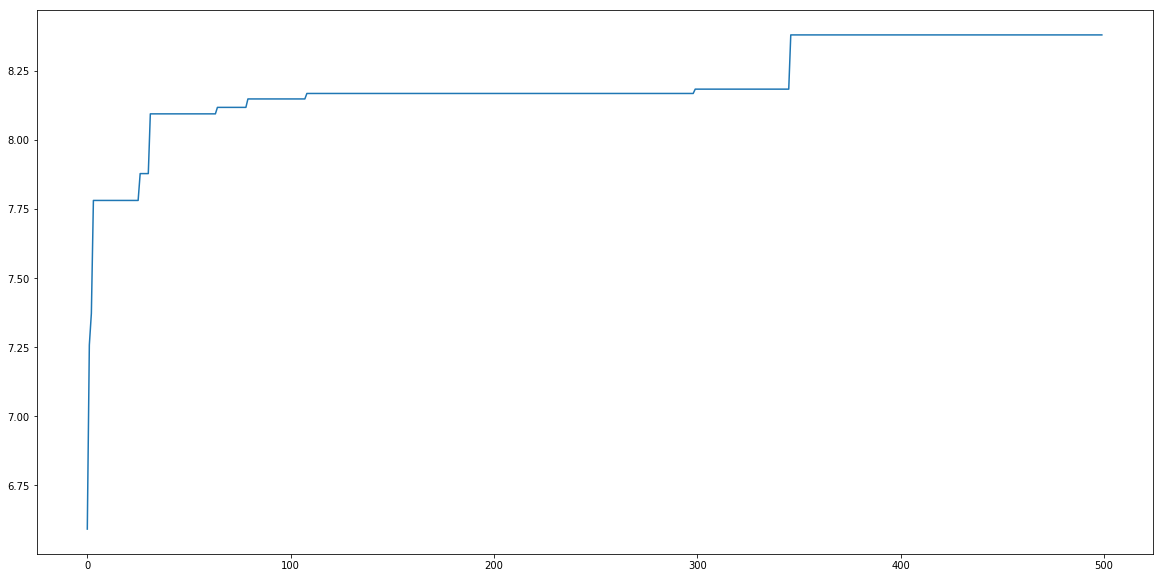

In [24]:
plt.figure(figsize=(20,10))
plt.plot(result)

In [25]:
bestLocation = pbest[np.argmax(fitnes(pbest)),:]
print("Maximum Value Values {:.6f}".format(result.max()))
print("X Values {:.4f}".format(bestLocation[0]))
print("Y Values {:.4f}".format(bestLocation[1]))

Maximum Value Values 8.380031
X Values -0.0060
Y Values -0.0051


In [26]:
#Eror percentage
maximum = func(0,0)
realout = func(bestLocation[0],bestLocation[1])
print("Maximum Point {:.8f}".format(maximum))
print("System Maximum Point {:.8f}".format(realout))
err = (maximum-realout)/maximum *100
print("Error Percentage {:.4f}".format(err))

Maximum Point 8.38905610
System Maximum Point 8.38003126
Error Percentage 0.1076


In [20]:
x = new_loc[:,0]
print(x)
x_pos = x[np.where((x>2))]
x_pos = np.where((x_pos<=3)&(x_pos>=2)==True,2-(x_pos%2),1-(x_pos%3))
x[np.where((x>2))] = x_pos
# Negatif
x_neg = x[np.where((x<-1))]
x_neg = np.where(((x_neg%-3)>-2)&((x_neg%-3)<-1)==True,-(2+((x_neg%-3)%-2)),((x_neg-2)%-4)+2)
x[np.where((x<-1))] = x_neg
print(x)

[-1.50869254e+00  4.17705593e-01 -6.00341023e-02 -3.91124698e+00
 -9.64396521e-01  8.37238121e-01 -1.36679253e+00 -2.34904010e+00
  1.98379056e+00  3.28578538e-02 -2.64409940e-01 -3.48550280e+00
 -1.92295971e+00 -2.85282822e+00 -1.58642584e-01  8.81895915e-01
 -6.50957335e-01 -1.54042943e+00  3.35318588e+00  1.99049091e-01
 -9.94226103e-01  4.29449576e-01  4.28502904e-03 -1.28675968e+00
 -5.09078390e-01  1.50971489e+00 -3.16362706e+00 -2.33406994e+00
 -6.46952199e-01 -2.26956427e+00 -9.10301302e-01  1.93989432e+00
  6.49691827e-01  1.11795590e+00 -6.35907122e-01 -2.62868652e+00
  2.75035882e+00 -1.86583358e+00 -3.07689036e+00  8.72745329e-01
 -2.99439867e+00  1.53602394e+00 -1.57634020e+00  7.51243686e-01
 -2.44502851e+00 -4.37470913e-01  7.97787090e-01  6.79622876e-01
  6.66403336e-01 -3.57126661e+00 -4.07205829e+00 -2.86799431e+00
 -2.89894121e+00 -4.08840458e+00 -4.27676241e+00 -3.18917328e-01
 -1.39921951e+00  1.01012294e+00  3.10587929e+00  2.11679765e+00
 -1.07699444e+00 -3.51354

In [237]:
x_pos = np.array([2.5,2.8,3,3.1,4,4.2,5.1,5.3,5.9,6])
print(x_pos)
x_pos = np.where((x_pos<=3)&(x_pos>=2)==True,2-(x_pos%2),2-(x_pos%3))
print(x_pos)

[2.5 2.8 3.  3.1 4.  4.2 5.1 5.3 5.9 6. ]
[ 1.5  1.2  1.   1.9  1.   0.8 -0.1 -0.3 -0.9  2. ]


In [376]:
x_neg = np.array([-1.5,-1.8,-2,-2.1,3,-3.4,-4.5,-5.5,-5.3,-5.9,-6,-6.4])
print(x_neg)
x_neg = (x_neg%-3)
x_neg = np.where((x_neg>-2)&(x_neg<-1)==True,x_neg+1,abs(x_neg+2))
print(x_neg)

[-1.5 -1.8 -2.  -2.1  3.  -3.4 -4.5 -5.5 -5.3 -5.9 -6.  -6.4]
[-0.5 -0.8  0.   0.1  2.   1.6 -0.5  0.5  0.3  0.9  2.   1.6]


In [192]:
y_neg = np.array([2,1,0,-1,-1.2,-2.5,-2.8,-3,-3.1,-3.7,-4,-4.2])
print(y_neg)
# y_neg=y_neg%-3
# print(y_neg)
y_neg = np.where(((y_neg%-3)>-3)&((y_neg%-3)<-2)==True,-(2+((y_neg%-3)%-2)),abs(y_neg%-3)-1)
print(y_neg)

[ 2.   1.   0.  -1.  -1.2 -2.5 -2.8 -3.  -3.1 -3.7 -4.  -4.2]
[ 0.   1.  -1.   0.   0.2 -1.5 -1.2 -1.  -0.9 -0.3  0.   0.2]


In [365]:
y = np.array([5,4,3,2,1,0,-1,-2,-3,-4,-5,-6,-7])
print(y)
#Negatif
y_neg = y[np.where((y<-2))]
y_neg = np.where(((y_neg%-3)>-3)&((y_neg%-3)<-2)==True,-(2+((y_neg%-3)%-2)),abs(y_neg%-3)-1)
y[np.where((y<-2))] = y_neg
print(y)

#Positif
y_pos = y[np.where((y>1))]
y_pos = np.where(((y_pos%3)<3)&((y_pos%3)>=1)==True,((y_pos%3)%2),((y_pos%3)-1))
y[np.where((y>1))] = y_pos
print(y)

[ 5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7]
[ 5  4  3  2  1  0 -1 -2 -1  0  1 -1  0]
[ 0  1 -1  0  1  0 -1 -2 -1  0  1 -1  0]


In [549]:
#Postif
x = np.array([5,4,3.7,3,2,1,0,-1,-1.2,-2,-2.5,-2.8,-3,-3.1,-4,-5])
print(x)
x_pos = x[np.where((x>2))]
x_pos = np.where((x_pos<=3)&(x_pos>=2)==True,2-(x_pos%2),1-(x_pos%3))
x[np.where((x>2))] = x_pos
print(x)
# Negatif
x_neg = x[np.where((x<-1))]
x_neg = np.where(((x_neg%-3)>-2)&((x_neg%-3)<-1)==True,-(2+((x_neg%-3)%-2)),((x_neg-2)%-4)+2)
x[np.where((x<-1))] = x_neg
print(x)

[ 5.   4.   3.7  3.   2.   1.   0.  -1.  -1.2 -2.  -2.5 -2.8 -3.  -3.1
 -4.  -5. ]
[-1.   0.   0.3  1.   2.   1.   0.  -1.  -1.2 -2.  -2.5 -2.8 -3.  -3.1
 -4.  -5. ]
[-1.   0.   0.3  1.   2.   1.   0.  -1.  -0.8  2.   1.5  1.2  1.   0.9
  0.  -1. ]


In [237]:
def boundviolation(new_loc):
    x = new_loc[:,0]
    x = np.array([5,4,3.7,3,2,1,0,-1,-1.2,-2,-2.5,-2.8,-3,-3.1,-4,-5])
    x_pos = x[np.where((x>2))]
    x_pos = np.where((x_pos<=3)&(x_pos>=2)==True,2-(x_pos%2),1-(x_pos%3))
    x[np.where((x>2))] = x_pos
    # Negatif
    x_neg = x[np.where((x<-1))]
    x_neg = np.where(((x_neg%-3)>-2)&((x_neg%-3)<-1)==True,-(2+((x_neg%-3)%-2)),((x_neg-2)%-4)+2)
    x[np.where((x<-1))] = x_neg
    
    #Negatif
    y_neg = y[np.where((y<-2))]
    y_neg = np.where(((y_neg%-3)>-3)&((y_neg%-3)<-2)==True,-(2+((y_neg%-3)%-2)),abs(y_neg%-3)-1)
    y[np.where((y<-2))] = y_neg
    #Positif
    y_pos = y[np.where((y>1))]
    y_pos = np.where(((y_pos%3)<3)&((y_pos%3)>=1)==True,((y_pos%3)%2),((y_pos%3)-1))
    y[np.where((y>1))] = y_pos
    return np.array([x,y]).T

In [238]:
a= boundviolation(new_loc)

In [242]:
y = a[:,1]
y<-2

array([False, False, False, False, False, False, False, False, False,
       False])

In [147]:
a=np.array([1.5,2.1,3,4,5,6,7,8,9,10,11])

In [148]:
a

array([ 1.5,  2.1,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. , 10. , 11. ])

In [166]:
a=np.array([1.5,2.1,3,4,5,6,7,8,9,10,11,12,13,14,15])
a = np.where(a>4,a,((a)%5)-3)
a = np.where(a<4,a,((a)%4)-2)

array([-1.5, -0.9,  0. ,  1. , -1. ,  0. ,  1. , -2. , -1. ,  0. ,  1. ,
       -2. , -1. ,  0. ,  1. ])

In [173]:
a=np.array([-2.5,-2.1,-3.4,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15])
a = np.where(a>-4,a,((a)%5)-3)
a = np.where(a<-4,a,((a)%5)-3)
a+1

array([ 0.5,  0.9, -0.4,  1. ,  0. , -1. , -2. ,  2. ,  1. ,  0. , -1. ,
       -2. ,  2. ,  1. ,  0. ])

In [115]:
((y)%5)-3

array([-1.8967099 , -1.20777551,  0.33213911, -1.40287572,  1.98443928,
        1.90259697, -1.58402425,  1.64243379,  1.95009359, -1.88865934])

In [179]:
a = np.array([2.1,3.2,4,5,6,7,8,9,10,11,12,13,14,15])
a = np.where(a>4,a,((a)%5)-4)
a = np.where(a<4,a,((a)%4)-2)
a

array([-1.9, -0.8,  0. , -1. ,  0. ,  1. , -2. , -1. ,  0. ,  1. , -2. ,
       -1. ,  0. ,  1. ])

In [206]:
x = new_loc[:,0]
x = np.where(x>-1,x,x+1)
x = np.where(x<2,x,x-2)

In [207]:
x

array([ 0.89783135,  0.5161073 ,  0.3446161 ,  0.98199762,  0.61942667,
       -0.4202759 ,  1.13907143, -0.53408299,  0.00359848,  0.93217079])

In [199]:
new_loc[:,0]

array([ 0.89783135,  2.5161073 ,  0.3446161 ,  2.98199762,  0.61942667,
       -0.4202759 ,  1.13907143, -0.53408299,  2.00359848,  2.93217079])

In [202]:
x = np.where(x<2,x,x-2)

array([ 0.89783135,  0.5161073 ,  0.3446161 ,  0.98199762,  0.61942667,
       -0.4202759 ,  1.13907143, -0.53408299,  0.00359848,  0.93217079])

In [218]:
y = a
y = np.where((y<1),y,(y-1)/(2+1))
y = np.where((y>-2),y,(y-1)/(2+1))
y

array([-1.66666667, -1.33333333, -1.        , -1.        ,  0.        ,
        0.        ,  0.33333333,  0.66666667,  1.        ])

In [213]:
a = np.array([-4,-3,-2,-1,0,1,2,3,4])

In [ ]:
# def boundviolation(new_loc):
#     x = new_loc[:,0]
#     y = new_loc[:,1]
#     for i in range(0,x.shape[0]):
#         #x_treatment -1≤x≤2
#         if x[i]>2:
#             x[i] = ((x[i]+1)%4)-1
#         if x[i]<-1:
#             x[i] = ((x[i]+1)%4)-1
#         #y_treatment -2≤y≤1
#         if y[i]>1:
#             y[i] = ((y[i]+2)%4)-2
#         if y[i]<-2:
#             y[i] = ((y[i]+2)%4)-2
#     return np.array([x,y]).T